***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

DONE loading Datasets
DONE loading MixUp Data generator


# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\GitHub Repo\HDeep_CapsNet\code\training\CIFAR_10
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "1" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  1
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


# Import Dataset : CIFAR-10

In [4]:
dataset = datasets.CIFAR10(version = 'ALL') # importing CIFAR10 Dataset
# dataset = datasets.CIFAR10(version = 'reduce') # importing CIFAR10 Dataset

CIFAR-10 dataset: Training have 50,000 samples and testing have 10,000 samples


# Parameters

In [5]:
from src.models import *

In [6]:
train_params = {"n_epochs" : 100,
                "batch_size": 64,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

## Learning Rate Decay Scheduler

In [7]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Bottom up Approach

## Loss Function

In [8]:
number_of_classes_c = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
number_of_classes_m = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
number_of_classes_f = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))

## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": number_of_classes_c,
                                "medium": number_of_classes_m,
                                "fine": number_of_classes_f})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [10]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")
    return total_marginloss

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F):
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = LW_M*margin_loss(y_true_m, y_pred_m)
    ML_f = LW_F*margin_loss(y_true_f, y_pred_f)
    batch_loss = ML_c + ML_m+ ML_f
    return tf.reduce_mean(batch_loss)

## Model Architecture

In [11]:
def get_compiled_model():
    input_shape = dataset['x_train'].shape[1:]

    input_shape_yc = dataset['y_train_coarse'].shape[1:]
    input_shape_ym = dataset['y_train_medium'].shape[1:]
    input_shape_yf = dataset['y_train_fine'].shape[1:]

    no_coarse_class = 2
    no_medium_class = 7
    no_fine_class = 10

    PCap_n_dims = 8

    SCap_f_dims = 16
    SCap_m_dims = 16
    SCap_c_dims = 16


    # Input image
    x_input = keras.layers.Input(shape=input_shape, name="Input_Image")

    # Input True Labels
    y_c = keras.layers.Input(shape=input_shape_yc, name='input_yc')
    y_m = keras.layers.Input(shape=input_shape_ym, name='input_ym')
    y_f = keras.layers.Input(shape=input_shape_yf, name='input_yf')

    #--- block 1 ---
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    #--- block 2 ---
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    #--- block 3 ---
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    #--- block 4 ---
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)


    # Layer 3: Reshape to 8D primary capsules 
    # input [batch_size, 6, 6, 512], output [batch_size, 2304, 8]
    reshapec = keras.layers.Reshape((256, PCap_n_dims), name="reshape_layer")(x)
    p_caps = keras.layers.Lambda(squash, name='p_caps')(reshapec)

    ## Layer Secondary Capsule: For fine level
    s_caps_f = SecondaryCapsule(n_caps=no_fine_class, n_dims=SCap_f_dims, 
                        name="s_caps_fine")(p_caps)

    ## Layer Secondary Capsule: For medium level
    s_caps_m = SecondaryCapsule(n_caps=no_medium_class, n_dims=SCap_f_dims, 
                        name="s_caps_medium")(s_caps_f)

    ## Layer Secondary Capsule: For coarse level
    s_caps_c = SecondaryCapsule(n_caps=no_coarse_class, n_dims=SCap_c_dims, 
                        name="s_caps_coarse")(s_caps_m)

    pred_c = LengthLayer(name='prediction_coarse')(s_caps_c)

    pred_m = LengthLayer(name='prediction_medium')(s_caps_m)

    pred_f = LengthLayer(name='prediction_fine')(s_caps_f)

    model = keras.Model(inputs= [x_input, y_c, y_m, y_f],
                        outputs= [pred_c, pred_m, pred_f],
                        name='HD-CapsNet')

    model.add_loss(CustomLoss(y_c, y_m, y_f, pred_c, pred_m, pred_f, 
                              lossweight['coarse_lw'], lossweight['medium_lw'], lossweight['fine_lw']))

    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'
                          }
    )
    return model

In [12]:
model = get_compiled_model()

## log directory

In [13]:
directory = sysenv.log_dir('HD_CapsNet/WO_C_loss')

FOLDER CREATED =  ./logs/HD_CapsNet/WO_C_loss


In [14]:
model.summary()
# keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 32, 32, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 32, 32, 64)   36928       ['batch_normalization[0]

                                                                                                  
 tf.math.subtract_3 (TFOpLambda  (None, 7)           0           ['prediction_medium[0][0]']      
 )                                                                                                
                                                                                                  
 tf.math.subtract_4 (TFOpLambda  (None, 7)           0           ['prediction_medium[0][0]']      
 )                                                                                                
                                                                                                  
 tf.math.maximum (TFOpLambda)   (None, 2)            0           ['tf.math.subtract[0][0]']       
                                                                                                  
 tf.math.subtract_2 (TFOpLambda  (None, 2)           0           ['input_yc[0][0]']               
 )        

 da)                                                                                              
                                                                                                  
 tf.math.add_2 (TFOpLambda)     (None, 10)           0           ['tf.math.multiply_8[0][0]',     
                                                                  'tf.math.multiply_10[0][0]']    
                                                                                                  
 tf.math.multiply_3 (TFOpLambda  (None,)             0           ['tf.math.reduce_sum[0][0]']     
 )                                                                                                
                                                                                                  
 tf.math.multiply_7 (TFOpLambda  (None,)             0           ['tf.math.reduce_sum_1[0][0]']   
 )                                                                                                
          

## Data Augmentation

In [15]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1)

training_generator = MixUp_add_loss.MixupGenerator_3level(dataset['x_train'],
                                                 dataset['y_train_coarse'], 
                                                 dataset['y_train_medium'],
                                                 dataset['y_train_fine'],
                                                 batch_size=train_params["batch_size"],
                                                 alpha=0.2, 
                                                 datagen=datagen
                                                )()

## Callback

In [16]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    directory+'/weights-{epoch:02d}.h5', 
    monitor='val_prediction_fine_accuracy',
    save_best_only=True, save_weights_only=True, verbose=1)
change_lw = LossWeightsModifier(lossweight = lossweight,
                               initial_lw = initial_lw,
                               directory = directory)
lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [17]:
history = model.fit(training_generator,
                    steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                    epochs = train_params["n_epochs"],
                    validation_data = ([dataset['x_test'],
                                        dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                       [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                    callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                    
                    verbose=1)
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.save_weights(model_save_dir)
    print('Trained model saved to = ', model_save_dir)
except:
    print('Model Wight is not saved')

Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 0.2709 - prediction_coarse_accuracy: 0.8843 - prediction_medium_accuracy: 0.5809 - prediction_fine_accuracy: 0.4340
  • Coarse Accuracy = 88.43% | Val_Accuracy = 92.25% | LossWeight = 0.16 
  • Medium Accuracy = 58.09% | Val_Accuracy = 68.32% | LossWeight = 0.42 
  • Fine   Accuracy = 43.40% | Val_Accuracy = 52.87% | LossWeight = 0.42 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.52870, saving model to ./logs/HD_CapsNet/WO_C_loss\weights-01.h5
781/781 [==============================] - 58s 64ms/step - loss: 0.2709 - prediction_coarse_accuracy: 0.8843 - prediction_medium_accuracy: 0.5809 - prediction_fine_accuracy: 0.4340 - val_loss: 0.1944 - val_prediction_coarse_accuracy: 0.9225 - val_prediction_medium_accuracy: 0.6832 - val_prediction_fine_accuracy: 0.5287 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 0.1733 - prediction_coarse_accuracy: 0.9252 - prediction_m

Epoch 10/100
781/781 [==============================] - ETA: 0s - loss: 0.0919 - prediction_coarse_accuracy: 0.9699 - prediction_medium_accuracy: 0.9042 - prediction_fine_accuracy: 0.8687
  • Coarse Accuracy = 96.99% | Val_Accuracy = 98.07% | LossWeight = 0.18 
  • Medium Accuracy = 90.42% | Val_Accuracy = 89.61% | LossWeight = 0.40 
  • Fine   Accuracy = 86.87% | Val_Accuracy = 85.61% | LossWeight = 0.42 

Epoch 10: val_prediction_fine_accuracy did not improve from 0.85870
781/781 [==============================] - 49s 62ms/step - loss: 0.0919 - prediction_coarse_accuracy: 0.9699 - prediction_medium_accuracy: 0.9042 - prediction_fine_accuracy: 0.8687 - val_loss: 0.0603 - val_prediction_coarse_accuracy: 0.9807 - val_prediction_medium_accuracy: 0.8961 - val_prediction_fine_accuracy: 0.8561 - lr: 0.0010
Epoch 11/100
781/781 [==============================] - ETA: 0s - loss: 0.0909 - prediction_coarse_accuracy: 0.9696 - prediction_medium_accuracy: 0.9073 - prediction_fine_accuracy: 0.8736

781/781 [==============================] - ETA: 0s - loss: 0.0734 - prediction_coarse_accuracy: 0.9789 - prediction_medium_accuracy: 0.9436 - prediction_fine_accuracy: 0.9226
  • Coarse Accuracy = 97.89% | Val_Accuracy = 97.98% | LossWeight = 0.21 
  • Medium Accuracy = 94.36% | Val_Accuracy = 91.46% | LossWeight = 0.39 
  • Fine   Accuracy = 92.26% | Val_Accuracy = 87.87% | LossWeight = 0.40 

Epoch 19: val_prediction_fine_accuracy did not improve from 0.88130
781/781 [==============================] - 48s 62ms/step - loss: 0.0734 - prediction_coarse_accuracy: 0.9789 - prediction_medium_accuracy: 0.9436 - prediction_fine_accuracy: 0.9226 - val_loss: 0.0511 - val_prediction_coarse_accuracy: 0.9798 - val_prediction_medium_accuracy: 0.9146 - val_prediction_fine_accuracy: 0.8787 - lr: 6.3025e-04
Epoch 20/100
781/781 [==============================] - ETA: 0s - loss: 0.0713 - prediction_coarse_accuracy: 0.9805 - prediction_medium_accuracy: 0.9473 - prediction_fine_accuracy: 0.9268
  • Coar

781/781 [==============================] - 49s 62ms/step - loss: 0.0661 - prediction_coarse_accuracy: 0.9826 - prediction_medium_accuracy: 0.9581 - prediction_fine_accuracy: 0.9458 - val_loss: 0.0447 - val_prediction_coarse_accuracy: 0.9861 - val_prediction_medium_accuracy: 0.9262 - val_prediction_fine_accuracy: 0.8947 - lr: 3.9721e-04
Epoch 29/100
781/781 [==============================] - ETA: 0s - loss: 0.0670 - prediction_coarse_accuracy: 0.9828 - prediction_medium_accuracy: 0.9575 - prediction_fine_accuracy: 0.9458
  • Coarse Accuracy = 98.28% | Val_Accuracy = 98.52% | LossWeight = 0.23 
  • Medium Accuracy = 95.75% | Val_Accuracy = 92.69% | LossWeight = 0.40 
  • Fine   Accuracy = 94.58% | Val_Accuracy = 89.82% | LossWeight = 0.38 

Epoch 29: val_prediction_fine_accuracy improved from 0.89470 to 0.89820, saving model to ./logs/HD_CapsNet/WO_C_loss\weights-29.h5
781/781 [==============================] - 49s 62ms/step - loss: 0.0670 - prediction_coarse_accuracy: 0.9828 - predictio

781/781 [==============================] - ETA: 0s - loss: 0.0637 - prediction_coarse_accuracy: 0.9839 - prediction_medium_accuracy: 0.9626 - prediction_fine_accuracy: 0.9549
  • Coarse Accuracy = 98.39% | Val_Accuracy = 98.62% | LossWeight = 0.24 
  • Medium Accuracy = 96.26% | Val_Accuracy = 92.71% | LossWeight = 0.40 
  • Fine   Accuracy = 95.49% | Val_Accuracy = 89.67% | LossWeight = 0.36 

Epoch 38: val_prediction_fine_accuracy did not improve from 0.89890
781/781 [==============================] - 47s 60ms/step - loss: 0.0637 - prediction_coarse_accuracy: 0.9839 - prediction_medium_accuracy: 0.9626 - prediction_fine_accuracy: 0.9549 - val_loss: 0.0436 - val_prediction_coarse_accuracy: 0.9862 - val_prediction_medium_accuracy: 0.9271 - val_prediction_fine_accuracy: 0.8967 - lr: 2.3783e-04
Epoch 39/100
781/781 [==============================] - ETA: 0s - loss: 0.0633 - prediction_coarse_accuracy: 0.9837 - prediction_medium_accuracy: 0.9618 - prediction_fine_accuracy: 0.9534
  • Coar

781/781 [==============================] - 46s 59ms/step - loss: 0.0634 - prediction_coarse_accuracy: 0.9829 - prediction_medium_accuracy: 0.9647 - prediction_fine_accuracy: 0.9563 - val_loss: 0.0413 - val_prediction_coarse_accuracy: 0.9866 - val_prediction_medium_accuracy: 0.9319 - val_prediction_fine_accuracy: 0.9029 - lr: 1.4989e-04
Epoch 48/100
781/781 [==============================] - ETA: 0s - loss: 0.0624 - prediction_coarse_accuracy: 0.9856 - prediction_medium_accuracy: 0.9663 - prediction_fine_accuracy: 0.9601
  • Coarse Accuracy = 98.56% | Val_Accuracy = 98.57% | LossWeight = 0.24 
  • Medium Accuracy = 96.63% | Val_Accuracy = 93.14% | LossWeight = 0.40 
  • Fine   Accuracy = 96.01% | Val_Accuracy = 90.37% | LossWeight = 0.36 

Epoch 48: val_prediction_fine_accuracy improved from 0.90290 to 0.90370, saving model to ./logs/HD_CapsNet/WO_C_loss\weights-48.h5
781/781 [==============================] - 47s 60ms/step - loss: 0.0624 - prediction_coarse_accuracy: 0.9856 - predictio

Epoch 57/100
781/781 [==============================] - ETA: 0s - loss: 0.0617 - prediction_coarse_accuracy: 0.9842 - prediction_medium_accuracy: 0.9650 - prediction_fine_accuracy: 0.9587
  • Coarse Accuracy = 98.42% | Val_Accuracy = 98.69% | LossWeight = 0.25 
  • Medium Accuracy = 96.50% | Val_Accuracy = 93.61% | LossWeight = 0.40 
  • Fine   Accuracy = 95.87% | Val_Accuracy = 90.73% | LossWeight = 0.35 

Epoch 57: val_prediction_fine_accuracy improved from 0.90660 to 0.90730, saving model to ./logs/HD_CapsNet/WO_C_loss\weights-57.h5
781/781 [==============================] - 47s 61ms/step - loss: 0.0617 - prediction_coarse_accuracy: 0.9842 - prediction_medium_accuracy: 0.9650 - prediction_fine_accuracy: 0.9587 - val_loss: 0.0401 - val_prediction_coarse_accuracy: 0.9869 - val_prediction_medium_accuracy: 0.9361 - val_prediction_fine_accuracy: 0.9073 - lr: 8.9745e-05
Epoch 58/100
781/781 [==============================] - ETA: 0s - loss: 0.0625 - prediction_coarse_accuracy: 0.9842 - pr

781/781 [==============================] - 47s 60ms/step - loss: 0.0617 - prediction_coarse_accuracy: 0.9847 - prediction_medium_accuracy: 0.9666 - prediction_fine_accuracy: 0.9602 - val_loss: 0.0395 - val_prediction_coarse_accuracy: 0.9875 - val_prediction_medium_accuracy: 0.9371 - val_prediction_fine_accuracy: 0.9086 - lr: 5.6562e-05
Epoch 67/100
781/781 [==============================] - ETA: 0s - loss: 0.0617 - prediction_coarse_accuracy: 0.9849 - prediction_medium_accuracy: 0.9658 - prediction_fine_accuracy: 0.9603
  • Coarse Accuracy = 98.49% | Val_Accuracy = 98.76% | LossWeight = 0.25 
  • Medium Accuracy = 96.58% | Val_Accuracy = 93.67% | LossWeight = 0.40 
  • Fine   Accuracy = 96.03% | Val_Accuracy = 90.86% | LossWeight = 0.35 

Epoch 67: val_prediction_fine_accuracy did not improve from 0.90990
781/781 [==============================] - 47s 60ms/step - loss: 0.0617 - prediction_coarse_accuracy: 0.9849 - prediction_medium_accuracy: 0.9658 - prediction_fine_accuracy: 0.9603 - 

781/781 [==============================] - ETA: 0s - loss: 0.0613 - prediction_coarse_accuracy: 0.9850 - prediction_medium_accuracy: 0.9672 - prediction_fine_accuracy: 0.9622
  • Coarse Accuracy = 98.50% | Val_Accuracy = 98.73% | LossWeight = 0.26 
  • Medium Accuracy = 96.72% | Val_Accuracy = 93.59% | LossWeight = 0.40 
  • Fine   Accuracy = 96.22% | Val_Accuracy = 90.88% | LossWeight = 0.34 

Epoch 76: val_prediction_fine_accuracy did not improve from 0.91030
781/781 [==============================] - 47s 60ms/step - loss: 0.0613 - prediction_coarse_accuracy: 0.9850 - prediction_medium_accuracy: 0.9672 - prediction_fine_accuracy: 0.9622 - val_loss: 0.0396 - val_prediction_coarse_accuracy: 0.9873 - val_prediction_medium_accuracy: 0.9359 - val_prediction_fine_accuracy: 0.9088 - lr: 3.3866e-05
Epoch 77/100
781/781 [==============================] - ETA: 0s - loss: 0.0615 - prediction_coarse_accuracy: 0.9845 - prediction_medium_accuracy: 0.9667 - prediction_fine_accuracy: 0.9608
  • Coar

781/781 [==============================] - 47s 60ms/step - loss: 0.0607 - prediction_coarse_accuracy: 0.9852 - prediction_medium_accuracy: 0.9670 - prediction_fine_accuracy: 0.9620 - val_loss: 0.0393 - val_prediction_coarse_accuracy: 0.9868 - val_prediction_medium_accuracy: 0.9362 - val_prediction_fine_accuracy: 0.9077 - lr: 2.1344e-05
Epoch 86/100
781/781 [==============================] - ETA: 0s - loss: 0.0611 - prediction_coarse_accuracy: 0.9851 - prediction_medium_accuracy: 0.9668 - prediction_fine_accuracy: 0.9610
  • Coarse Accuracy = 98.51% | Val_Accuracy = 98.66% | LossWeight = 0.25 
  • Medium Accuracy = 96.68% | Val_Accuracy = 93.57% | LossWeight = 0.40 
  • Fine   Accuracy = 96.10% | Val_Accuracy = 90.69% | LossWeight = 0.35 

Epoch 86: val_prediction_fine_accuracy did not improve from 0.91030
781/781 [==============================] - 47s 60ms/step - loss: 0.0611 - prediction_coarse_accuracy: 0.9851 - prediction_medium_accuracy: 0.9668 - prediction_fine_accuracy: 0.9610 - 

781/781 [==============================] - ETA: 0s - loss: 0.0616 - prediction_coarse_accuracy: 0.9844 - prediction_medium_accuracy: 0.9660 - prediction_fine_accuracy: 0.9602
  • Coarse Accuracy = 98.44% | Val_Accuracy = 98.71% | LossWeight = 0.26 
  • Medium Accuracy = 96.60% | Val_Accuracy = 93.76% | LossWeight = 0.40 
  • Fine   Accuracy = 96.02% | Val_Accuracy = 90.78% | LossWeight = 0.35 

Epoch 95: val_prediction_fine_accuracy did not improve from 0.91030
781/781 [==============================] - 47s 60ms/step - loss: 0.0616 - prediction_coarse_accuracy: 0.9844 - prediction_medium_accuracy: 0.9660 - prediction_fine_accuracy: 0.9602 - val_loss: 0.0392 - val_prediction_coarse_accuracy: 0.9871 - val_prediction_medium_accuracy: 0.9376 - val_prediction_fine_accuracy: 0.9078 - lr: 1.2779e-05
Epoch 96/100
781/781 [==============================] - ETA: 0s - loss: 0.0612 - prediction_coarse_accuracy: 0.9855 - prediction_medium_accuracy: 0.9668 - prediction_fine_accuracy: 0.9613
  • Coar

In [18]:
history_dict = history.history

(0.0, 1.0)

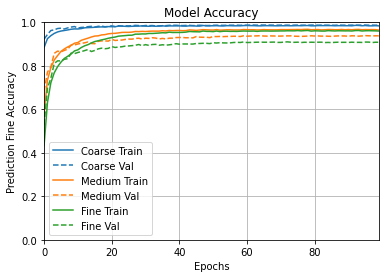

In [19]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
plt.title("Model Accuracy")
plt.ylim([0,1])

(0.0, 1.0)

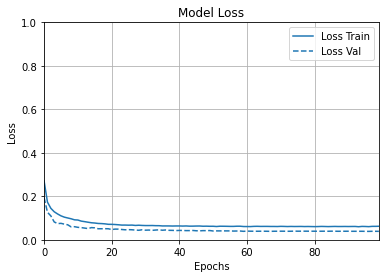

In [20]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"loss": history}, metric = "loss")
plt.title("Model Loss")
plt.ylim([0,1])

## Model Analysis

In [21]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : MarginLoss(),
                          'prediction_medium' : MarginLoss(),
                          'prediction_coarse' : MarginLoss()},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 8s 17ms/step - loss: 0.0516 - prediction_coarse_loss: 0.0140 - prediction_medium_loss: 0.0538 - prediction_fine_loss: 0.0775 - prediction_coarse_accuracy: 0.9872 - prediction_medium_accuracy: 0.9381 - prediction_fine_accuracy: 0.9084
1. loss ==> 0.05155700072646141
2. prediction_coarse_loss ==> 0.013999046757817268
3. prediction_medium_loss ==> 0.05381801724433899
4. prediction_fine_loss ==> 0.07752087712287903
5. prediction_coarse_accuracy ==> 0.9872000217437744
6. prediction_medium_accuracy ==> 0.9380999803543091
7. prediction_fine_accuracy ==> 0.9083999991416931
313/313 [==============================] - 4s 11ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

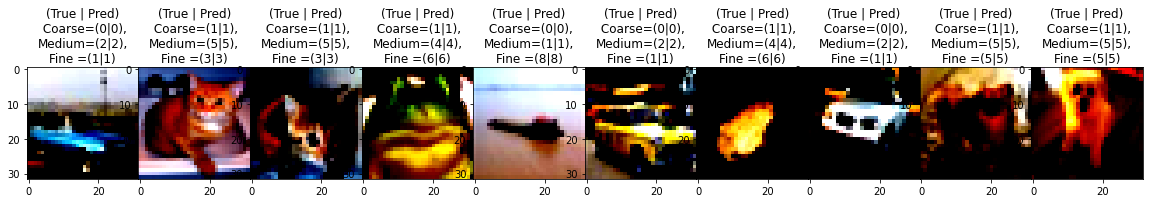

In [22]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[3949   51]
 [  77 5923]]

  • MEDIUM LEVEL 
[[ 943   19   14   15    3    2    4]
 [  30  948   13    3    2    3    1]
 [  11   10 1970    4    1    2    2]
 [  22    2    0  885   19   48   24]
 [   4    1    4   10  946   27    8]
 [  16    5   13   43   43 1823   57]
 [  11    2    2   33   25   61 1866]]

  • FINE LEVEL 
[[939   9  15   1   4   1   3   2  18   8]
 [  4 966   3   0   0   0   0   0   3  24]
 [ 22   0 880  26  19  20  22   9   2   0]
 [  9   3  33 781  24  90  38  14   2   6]
 [  7   1  21  18 898  11  24  17   2   1]
 [  6   2  16  89  17 844  11  10   3   2]
 [  4   1  11  21   6   3 950   1   1   2]
 [  4   2  10  10  21  13   3 934   1   2]
 [ 29   7   4   2   2   1   1   0 947   7]
 [  6  35   1   1   0   1   1   2   8 945]]

  • Classification Report 


  • COARSE LEVEL 


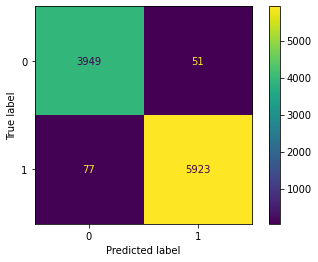

              precision    recall  f1-score   support

           0    0.98087   0.98725   0.98405      4000
           1    0.99146   0.98717   0.98931      6000

    accuracy                        0.98720     10000
   macro avg    0.98617   0.98721   0.98668     10000
weighted avg    0.98723   0.98720   0.98721     10000


  • MEDIUM LEVEL 


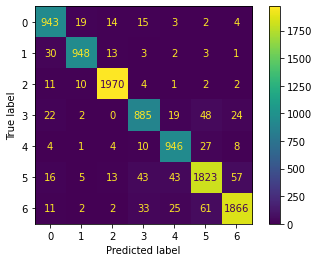

              precision    recall  f1-score   support

           0    0.90935   0.94300   0.92587      1000
           1    0.96049   0.94800   0.95420      1000
           2    0.97718   0.98500   0.98108      2000
           3    0.89124   0.88500   0.88811      1000
           4    0.91049   0.94600   0.92791      1000
           5    0.92726   0.91150   0.91931      2000
           6    0.95107   0.93300   0.94195      2000

    accuracy                        0.93810     10000
   macro avg    0.93244   0.93593   0.93406     10000
weighted avg    0.93826   0.93810   0.93808     10000


  • FINE LEVEL 


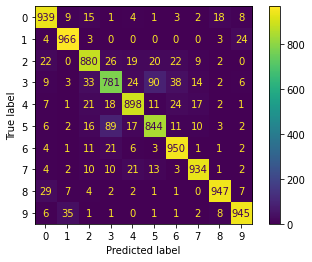

              precision    recall  f1-score   support

           0    0.91165   0.93900   0.92512      1000
           1    0.94152   0.96600   0.95360      1000
           2    0.88531   0.88000   0.88265      1000
           3    0.82297   0.78100   0.80144      1000
           4    0.90616   0.89800   0.90206      1000
           5    0.85772   0.84400   0.85081      1000
           6    0.90218   0.95000   0.92547      1000
           7    0.94439   0.93400   0.93917      1000
           8    0.95947   0.94700   0.95320      1000
           9    0.94784   0.94500   0.94642      1000

    accuracy                        0.90840     10000
   macro avg    0.90792   0.90840   0.90799     10000
weighted avg    0.90792   0.90840   0.90799     10000



In [23]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [24]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.9440533333333333 
Hierarchical Recall = 0.9459 
Hierarchical F1-Score = 0.9448119047619048 
Consistency =  0.9906 
Exact Match =  0.9056
